# Dataset and imports

We choose the built-in breast cancer dataset (binary classification).

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
data = load_breast_cancer()
X, y = data.data, data.target

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=0)
Xtrain, Xvalid, ytrain, yvalid = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=0)

print(f"Training set: {Xtrain.shape, ytrain.shape}")
print(f"Validation set: {Xvalid.shape, yvalid.shape}")
print(f"Test set: {Xtest.shape, ytest.shape}")

Training set: ((318, 30), (318,))
Validation set: ((137, 30), (137,))
Test set: ((114, 30), (114,))


# Before we begin:  **Helper Questions**

1. **Would a different threshold yield better results?**  
   - How does shifting the threshold affect the **trade-off between sensitivity and specificity**?

   Sensitivity = True Positive Rate
   Specificity = 1 - False Positive Rate

   When we lift up the threshold, we need higher probability to predict $class = 1$, so we tend to predict less observations as $class = 1$. This results in classifying more True Positives as Negatives, which decreases TPR. On the other hand, this increases the number of ???

2. **How do you define "better" results?**  
   - Is **higher specificity** more valuable than **higher sensitivity** in certain contexts? Or maybe the other way around?
   - Does the **best threshold** depend on the task? (discuss cases like *disease detection* vs. *spam filtering*)

3. **How does a ROC curve help in this process?**  
   - Learn how to use a **ROC curve** to visualize the trade-off between **True Positive Rate (Sensitivity)** and **False Positive Rate (1 - Specificity)**.

4. **How do you select the optimal threshold using the ROC curve?**  
   - Discuss strategies to select a threshold depending on the specific task at hand and the acceptable **trade-off between sensitivity and specificity**.

5. **What is the AUC metric and how is it useful?**  
   - Define **AUC (Area Under the Curve)** and discuss its role in evaluating the overall performance of a classifier.

# Logistic Regression
We now perform LR on this dataset and extract predicted probabilities in order to analyze the influece of established threshold. After that, we calculate the AUC metric (area under ROC curve - the bigger, the better, max=1.0)

In [3]:
lr_model = LogisticRegression(penalty=None, max_iter=1000).fit(Xtrain, ytrain)

ypred = lr_model.predict_proba(Xvalid)[:, 1]
fpr, tpr, thresholds = roc_curve(yvalid, ypred)
roc_auc = auc(fpr, tpr)

Given the False Positive Rate and True Positive Rate (building blocks of ROC curve) we can now extract the best possible threshold. We want to simultaneously minimize FPR and maximize TPR and in order to do so, we have to use some heuristics. Our choice here would be to simply minimize the (euclidean) distance od ROC curve point from $(FPR, TPR) = (0, 1)$ (top-left corner).

In [ ]:
roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})
roc_df['dist_to_(0, 1)'] = np.sqrt((roc_df['fpr'] - 0.0)**2 + (roc_df['tpr'] - 1.0)**2)
roc_df = roc_df.sort_values('dist_to_(0, 1)')
best_fpr_tpr = roc_df.iloc[0, [0, 1]].values
best_threshold = roc_df.iloc[0, 2]

print(f"AUC score: {roc_auc:.4f}")
print(f"Best FPR: {best_fpr_tpr[0]:.4f}")
print(f"Best TPR: {best_fpr_tpr[1]:.4f}")
print(f"Best threshold: {best_threshold:.4f}")

AUC score: 0.9887
Best FPR: 0.0577
Best TPR: 0.9529
Best threshold: 0.1470


We visualize the described method on the ROC plot below.

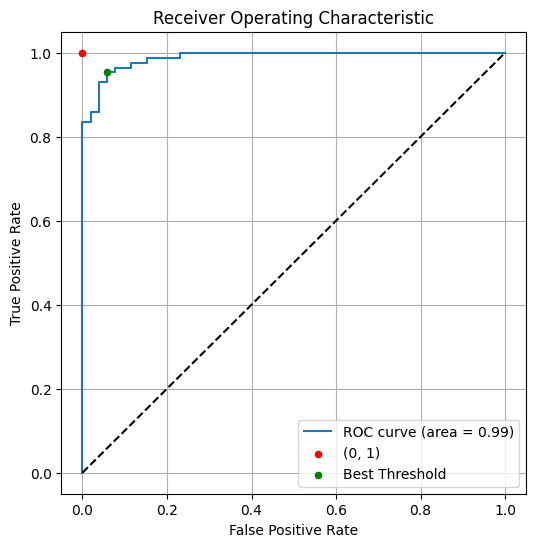

In [5]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
ax.plot([0, 1], [0, 1], 'k--')
ax.grid(visible=True)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')

ax.scatter(0.0, 1.0, c='red', s=20, zorder=10, label='(0, 1)')
ax.scatter(best_fpr_tpr[0], best_fpr_tpr[1], c='green', s=20, zorder=10, label='Best Threshold')

ax.legend()
plt.show()

We now apply the threshold to test set and compute the metrics:

In [6]:
lr_model = LogisticRegression(penalty=None, max_iter=1000).fit(Xtest, ytest)
ypred = np.where(lr_model.predict_proba(Xtest)[:, 1] > best_threshold, 1, 0)

accuracy = accuracy_score(ytest, ypred)
precision = precision_score(ytest, ypred)
recall = recall_score(ytest, ypred)
f1 = f1_score(ytest, ypred)
conf_matrix = confusion_matrix(ytest, ypred)

The model performs perfectly on the test set!

In [7]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")
print(f"Confusion matrix:\n{conf_matrix}")

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 score: 1.0000
Confusion matrix:
[[47  0]
 [ 0 67]]
